In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [5]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [7]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [8]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(Adam(lr=1e-5, beta_2 = 0.99), loss=loss, metrics=['accuracy'])

    return model

In [9]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=64*strategy.num_replicas_in_sync) 

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.3949 - accuracy: 0.24 - ETA: 0s - loss: 1.3944 - accuracy: 0.24 - ETA: 0s - loss: 1.3922 - accuracy: 0.24 - ETA: 0s - loss: 1.3906 - accuracy: 0.25 - ETA: 0s - loss: 1.3900 - accuracy: 0.25 - ETA: 0s - loss: 1.3873 - accuracy: 0.27 - 98s 16s/step - loss: 1.3873 - accuracy: 0.2705 - val_loss: 1.3650 - val_accuracy: 0.3392
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.3700 - accuracy: 0.31 - ETA: 0s - loss: 1.3658 - accuracy: 0.32 - ETA: 0s - loss: 1.3593 - accuracy: 0.34 - ETA: 0s - loss: 1.3549 - accuracy: 0.35 - ETA: 0s - loss: 1.3507 - accuracy: 0.35 - ETA: 0s - loss: 1.3454 - accuracy: 0.37 - 3s 429ms/step - loss: 1.3454 - accuracy: 0.3700 - val_loss: 1.3099 - val_accuracy: 0.4229
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.3007 - accuracy: 0.44 - ETA: 0s - loss: 1.2866 - accuracy: 0.46 - ETA: 0s - loss: 1.2832 - accuracy: 0.47 - ETA: 0s - loss: 1.2724 - accuracy: 0.4

Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 0.8762 - accuracy: 0.86 - ETA: 0s - loss: 0.8567 - accuracy: 0.88 - ETA: 0s - loss: 0.8520 - accuracy: 0.89 - ETA: 0s - loss: 0.8547 - accuracy: 0.89 - ETA: 0s - loss: 0.8496 - accuracy: 0.89 - ETA: 0s - loss: 0.8490 - accuracy: 0.89 - 3s 422ms/step - loss: 0.8490 - accuracy: 0.8992 - val_loss: 1.0555 - val_accuracy: 0.6828
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.87 - ETA: 0s - loss: 0.8507 - accuracy: 0.88 - ETA: 0s - loss: 0.8509 - accuracy: 0.89 - ETA: 0s - loss: 0.8502 - accuracy: 0.89 - ETA: 0s - loss: 0.8450 - accuracy: 0.89 - ETA: 0s - loss: 0.8445 - accuracy: 0.89 - 3s 419ms/step - loss: 0.8445 - accuracy: 0.8998 - val_loss: 1.0607 - val_accuracy: 0.6784
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.90 - ETA: 0s - loss: 0.8411 - accuracy: 0.90 - ETA: 0s - loss: 0.8508 - accuracy: 0.89 - ETA: 0s - loss: 0.8553 - accuracy:

Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.94 - ETA: 0s - loss: 0.8038 - accuracy: 0.94 - ETA: 0s - loss: 0.8035 - accuracy: 0.94 - ETA: 0s - loss: 0.8042 - accuracy: 0.94 - ETA: 0s - loss: 0.8030 - accuracy: 0.94 - ETA: 0s - loss: 0.8008 - accuracy: 0.94 - 3s 421ms/step - loss: 0.8008 - accuracy: 0.9448 - val_loss: 1.0429 - val_accuracy: 0.7034
Epoch 44/100
6/6 [==============================] - ETA: 0s - loss: 0.7986 - accuracy: 0.94 - ETA: 0s - loss: 0.7972 - accuracy: 0.94 - ETA: 0s - loss: 0.7991 - accuracy: 0.94 - ETA: 0s - loss: 0.7996 - accuracy: 0.94 - ETA: 0s - loss: 0.8009 - accuracy: 0.94 - ETA: 0s - loss: 0.7999 - accuracy: 0.94 - 3s 423ms/step - loss: 0.7999 - accuracy: 0.9448 - val_loss: 1.0538 - val_accuracy: 0.6828
Epoch 45/100
6/6 [==============================] - ETA: 0s - loss: 0.8087 - accuracy: 0.93 - ETA: 0s - loss: 0.8035 - accuracy: 0.94 - ETA: 0s - loss: 0.7967 - accuracy: 0.94 - ETA: 0s - loss: 0.7998 - accuracy:

Epoch 64/100
6/6 [==============================] - ETA: 0s - loss: 0.7885 - accuracy: 0.95 - ETA: 0s - loss: 0.7911 - accuracy: 0.95 - ETA: 0s - loss: 0.7866 - accuracy: 0.95 - ETA: 0s - loss: 0.7867 - accuracy: 0.95 - ETA: 0s - loss: 0.7899 - accuracy: 0.95 - ETA: 0s - loss: 0.7896 - accuracy: 0.95 - 3s 420ms/step - loss: 0.7896 - accuracy: 0.9544 - val_loss: 1.0290 - val_accuracy: 0.7107
Epoch 65/100
6/6 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.94 - ETA: 0s - loss: 0.7904 - accuracy: 0.95 - ETA: 0s - loss: 0.7944 - accuracy: 0.95 - ETA: 0s - loss: 0.7930 - accuracy: 0.95 - ETA: 0s - loss: 0.7943 - accuracy: 0.94 - ETA: 0s - loss: 0.7920 - accuracy: 0.95 - 3s 438ms/step - loss: 0.7920 - accuracy: 0.9517 - val_loss: 1.0456 - val_accuracy: 0.6946
Epoch 66/100
6/6 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.96 - ETA: 0s - loss: 0.7882 - accuracy: 0.95 - ETA: 0s - loss: 0.7896 - accuracy: 0.95 - ETA: 0s - loss: 0.7917 - accuracy:

Epoch 85/100
6/6 [==============================] - ETA: 0s - loss: 0.7849 - accuracy: 0.95 - ETA: 0s - loss: 0.7855 - accuracy: 0.95 - ETA: 0s - loss: 0.7854 - accuracy: 0.95 - ETA: 0s - loss: 0.7833 - accuracy: 0.96 - ETA: 0s - loss: 0.7829 - accuracy: 0.96 - ETA: 0s - loss: 0.7824 - accuracy: 0.96 - 3s 419ms/step - loss: 0.7824 - accuracy: 0.9611 - val_loss: 1.0212 - val_accuracy: 0.7122
Epoch 86/100
6/6 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.96 - ETA: 0s - loss: 0.7768 - accuracy: 0.96 - ETA: 0s - loss: 0.7781 - accuracy: 0.96 - ETA: 0s - loss: 0.7798 - accuracy: 0.96 - ETA: 0s - loss: 0.7782 - accuracy: 0.96 - ETA: 0s - loss: 0.7804 - accuracy: 0.96 - 3s 420ms/step - loss: 0.7804 - accuracy: 0.9637 - val_loss: 1.0289 - val_accuracy: 0.7093
Epoch 87/100
6/6 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.96 - ETA: 0s - loss: 0.7819 - accuracy: 0.96 - ETA: 0s - loss: 0.7813 - accuracy: 0.96 - ETA: 0s - loss: 0.7797 - accuracy:

In [11]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


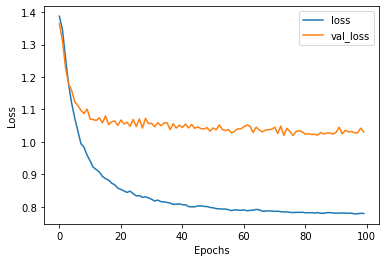

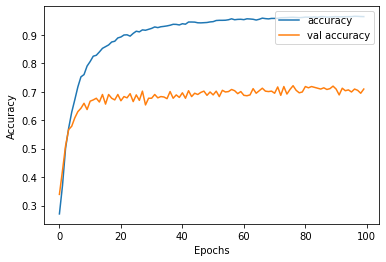

In [12]:
plot_learning_curve(history)

In [13]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.68 - ETA: 0s - loss: 1.0614 - accuracy: 0.64 - ETA: 0s - loss: 1.0281 - accuracy: 0.70 - ETA: 0s - loss: 1.0244 - accuracy: 0.70 - ETA: 0s - loss: 1.0283 - accuracy: 0.70 - ETA: 0s - loss: 1.0435 - accuracy: 0.68 - ETA: 0s - loss: 1.0527 - accuracy: 0.68 - ETA: 0s - loss: 1.0459 - accuracy: 0.68 - ETA: 0s - loss: 1.0520 - accuracy: 0.68 - ETA: 0s - loss: 1.0404 - accuracy: 0.69 - ETA: 0s - loss: 1.0463 - accuracy: 0.69 - 7s 311ms/step - loss: 1.0463 - accuracy: 0.6921
